## Environmental Source Apportionment Toolkit (ESAT) Solution Eval


In [1]:
# Notebook imports
import os
import sys
import json
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss, qr_loss

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [3]:
seed = 42

syn_factors = 6
syn_features = 40
syn_samples = 200

rng = np.random.default_rng(seed)
syn_factor_profiles = np.zeros(shape=(syn_factors, syn_features))
syn_factor_contributions = rng.random(size=(syn_samples, syn_factors)) * 10
factor_list = list(range(syn_factors))
for i in range(syn_features):
    factor_features_n = rng.integers(1, syn_factors, 1)     # Number of factors which will have a non-zero value in the profile for this feature
    factor_feature_selected = rng.choice(factor_list, size=factor_features_n, replace=False)     # The specific factors which have a non-zero value in the profile for this feature
    for j in factor_feature_selected:
        ij_value = rng.random(size=1)
        syn_factor_profiles[j, i] = ij_value

syn_factor_profiles[syn_factor_profiles == 0.0] = 1e-12

syn_data = np.matmul(syn_factor_contributions, syn_factor_profiles)
noise = syn_data * np.random.normal(loc=0.01, scale=0.005, size=syn_data.shape)
syn_data = np.add(syn_data, noise)

syn_unc_p = np.random.normal(loc=0.05, scale=0.002, size=syn_data.shape)
syn_uncertainty = syn_data * syn_unc_p
syn_uncertainty[syn_uncertainty <= 0.0] = 1e-12

C:\Users\dsmith\AppData\Local\Temp\ipykernel_2892\3032736096.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  syn_factor_profiles[j, i] = ij_value


In [4]:
syn_columns = [f"Feature {i}" for i in range(1, syn_features+1)]
syn_input_df = pd.DataFrame(syn_data, columns=syn_columns)
syn_uncertainty_df = pd.DataFrame(syn_uncertainty, columns=syn_columns)

#### Input Parameters

In [5]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = 6                         # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible
parallel = True                     # execute the model training in parallel, multiple models at the same time

In [6]:
syn_sa = SA(V=syn_input_df.to_numpy(), U=syn_uncertainty_df.to_numpy(), factors=factors, seed=seed, optimized=optimized, parallelized=parallel, verbose=verbose)
syn_sa.H = syn_factor_profiles
syn_sa.W = syn_factor_contributions
syn_sa.WH = syn_data
syn_sa.Qrobust = qr_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)
syn_sa.Qtrue = q_loss(V=syn_sa.V, U=syn_sa.U, W=syn_sa.W, H=syn_sa.H)

syn_factor_columns = [f"Factor {i}" for i in range(1, factors+1)]
syn_profile_df = pd.DataFrame(syn_factor_profiles.T, columns=syn_factor_columns)
syn_contribution_df = pd.DataFrame(syn_factor_contributions, columns=syn_factor_columns)

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [7]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [8]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

Category        S/N       Min       25th       50th       75th  \
Feature 1    Strong  19.040413  0.040837   1.774553   2.874149   4.211824   
Feature 2    Strong  18.946214  0.020094   0.267677   0.359617   0.509236   
Feature 3    Strong  19.014560  3.908030  10.670856  13.242284  15.726681   
Feature 4    Strong  19.030195  0.013207   1.275734   2.649251   4.441614   
Feature 5    Strong  19.025125  3.582409  10.009608  13.034867  16.471503   
Feature 6    Strong  18.988583  0.008012   1.109029   2.326397   3.577028   
Feature 7    Strong  19.063804  1.639816   6.411038   8.220596  10.012031   
Feature 8    Strong  19.009853  0.340718   2.722303   3.750210   4.759648   
Feature 9    Strong  19.001495  0.793890   7.707345  10.441742  13.332969   
Feature 10   Strong  19.046085  1.770626  10.052135  13.204375  15.886451   
Feature 11   Strong  18.923187  2.039273  10.663314  13.148744  15.960078   
Feature 12   Strong  18.990165  2.103519   7.389777   8.954656  10.967113   
Feature 13   Strong  19.088666  0.560900   5.190532   7.759533   9.714748   
Feature 14   Strong  19.116105  0.858593   9.679120  12.530287  15.715631   
Feature 15   Strong  19.049095  1.225543   8.172509  10.510667  12.370496   
Feature 16   Strong  18.964018  2.651305   8.679158  11.064782  13.250800   
Feature 17   Strong  19.058431  0.397051   6.393186   8.983346  11.117309   
Feature 18   Strong  18.956869  1.633079  11.728979  14.788819  17.723236   
Feature 19   Strong  18.923431  0.036205   1.868185   3.878082   5.974309   
Feature 20   Strong  18.979735  2.127962  12.013866  15.269340  18.310362   
Feature 21   Strong  18.955674  0.004465   2.488275   4.588881   6.389740   
Feature 22   Strong  19.050679  5.001190  13.874164  17.260809  20.738561   
Feature 23   Strong  19.033335  2.018313   9.414837  12.219053  14.449263   
Feature 24   Strong  19.089843  1.499198   8.409304  10.426536  12.544590   
Feature 25   Strong  19.017794  4.605399  12.152848  15.952129  19.697657   
Feature 26   Strong  18.953938  0.271715   3.329417   4.585247   5.638388   
Feature 27   Strong  19.123056  0.016504   2.436837   4.941543   7.428753   
Feature 28   Strong  18.978736  0.035337   2.970069   5.088427   7.095428   
Feature 29   Strong  19.025716  0.063206   0.635935   0.909444   1.247173   
Feature 30   Strong  19.034005  0.000819   0.452017   0.841077   1.156675   
Feature 31   Strong  19.007486  0.700842   6.474613   9.551822  11.393866   
Feature 32   Strong  19.093559  5.090302  13.369873  16.912147  20.547436   
Feature 33   Strong  18.998287  2.804876  11.709125  15.084651  17.947191   
Feature 34   Strong  19.043054  0.454435   4.564798   5.960531   7.075578   
Feature 35   Strong  19.018112  0.003140   0.151934   0.365089   0.599860   
Feature 36   Strong  19.020432  0.331414   2.514325   3.981765   5.636684   
Feature 37   Strong  19.020715  1.197597   4.811085   7.554522   9.895872   
Feature 38   Strong  19.002939  0.013315   1.287974   2.672010   4.461795   
Feature 39   Strong  18.998065  0.280760   2.436123   4.200472   5.792734   
Feature 40   Strong  19.056463  0.372505   5.291697   7.575134   9.462910   

                  Max  
Feature 1    5.547398  
Feature 2    0.721396  
Feature 3   23.096771  
Feature 4    5.717524  
Feature 5   23.688116  
Feature 6    4.796397  
Feature 7   14.240053  
Feature 8    6.849491  
Feature 9   19.200580  
Feature 10  21.783277  
Feature 11  23.146698  
Feature 12  15.049415  
Feature 13  13.733208  
Feature 14  24.574105  
Feature 15  17.349145  
Feature 16  18.455797  
Feature 17  15.504042  
Feature 18  23.927994  
Feature 19   8.029084  
Feature 20  23.820538  
Feature 21   8.629215  
Feature 22  28.983461  
Feature 23  20.348501  
Feature 24  17.325826  
Feature 25  28.435792  
Feature 26   8.560869  
Feature 27  10.029756  
Feature 28   9.480222  
Feature 29   1.729155  
Feature 30   1.573613  
Feature 31  16.016084  
Feature 32  28.696009  
Feature 33  27.573220  
Feature 34  10.308874  
Feature 35   

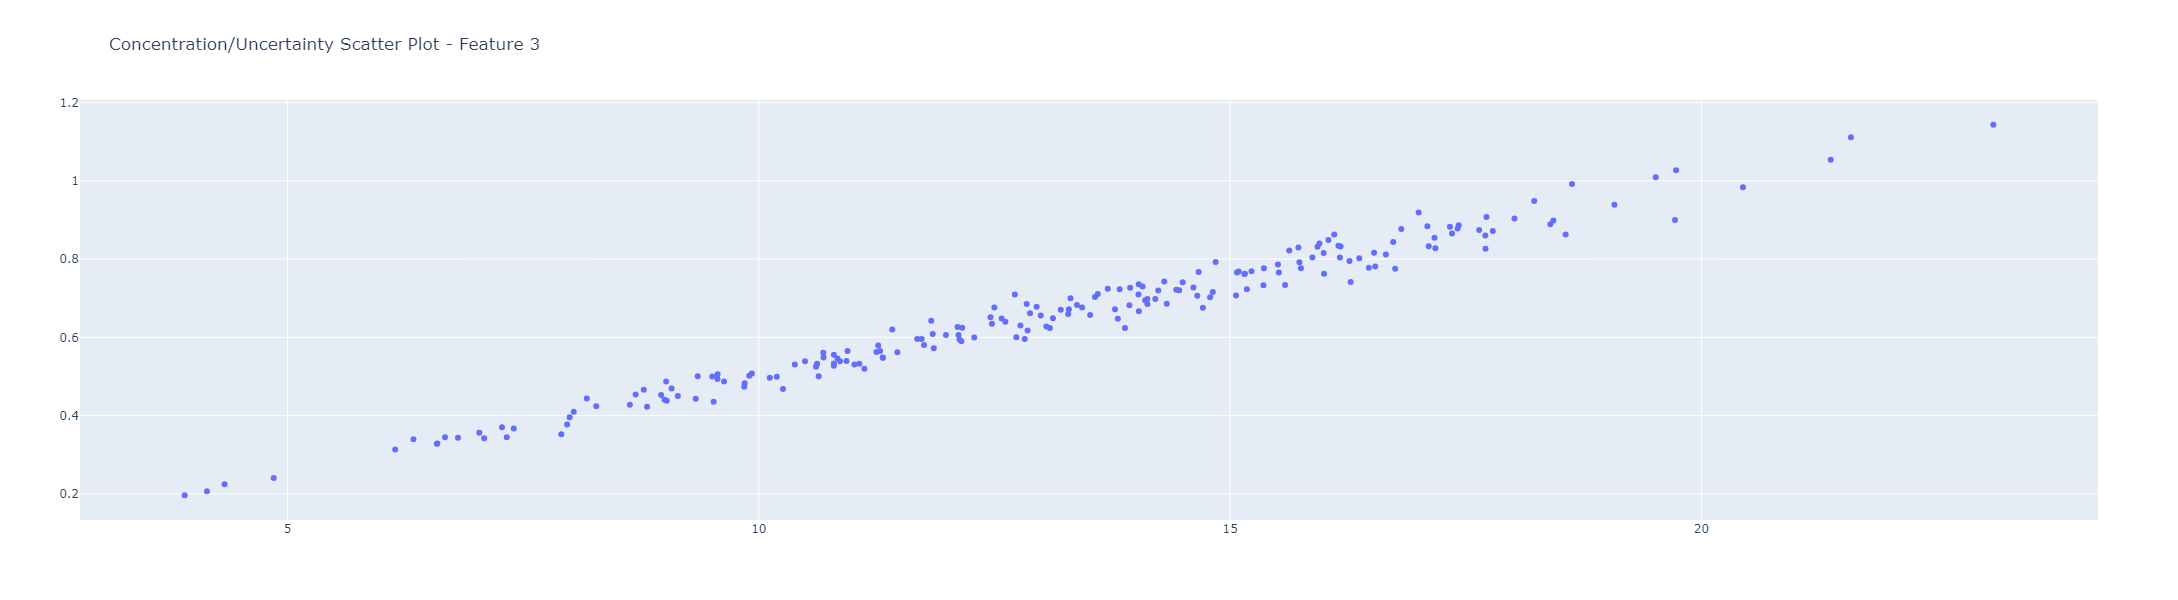

In [9]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=2)

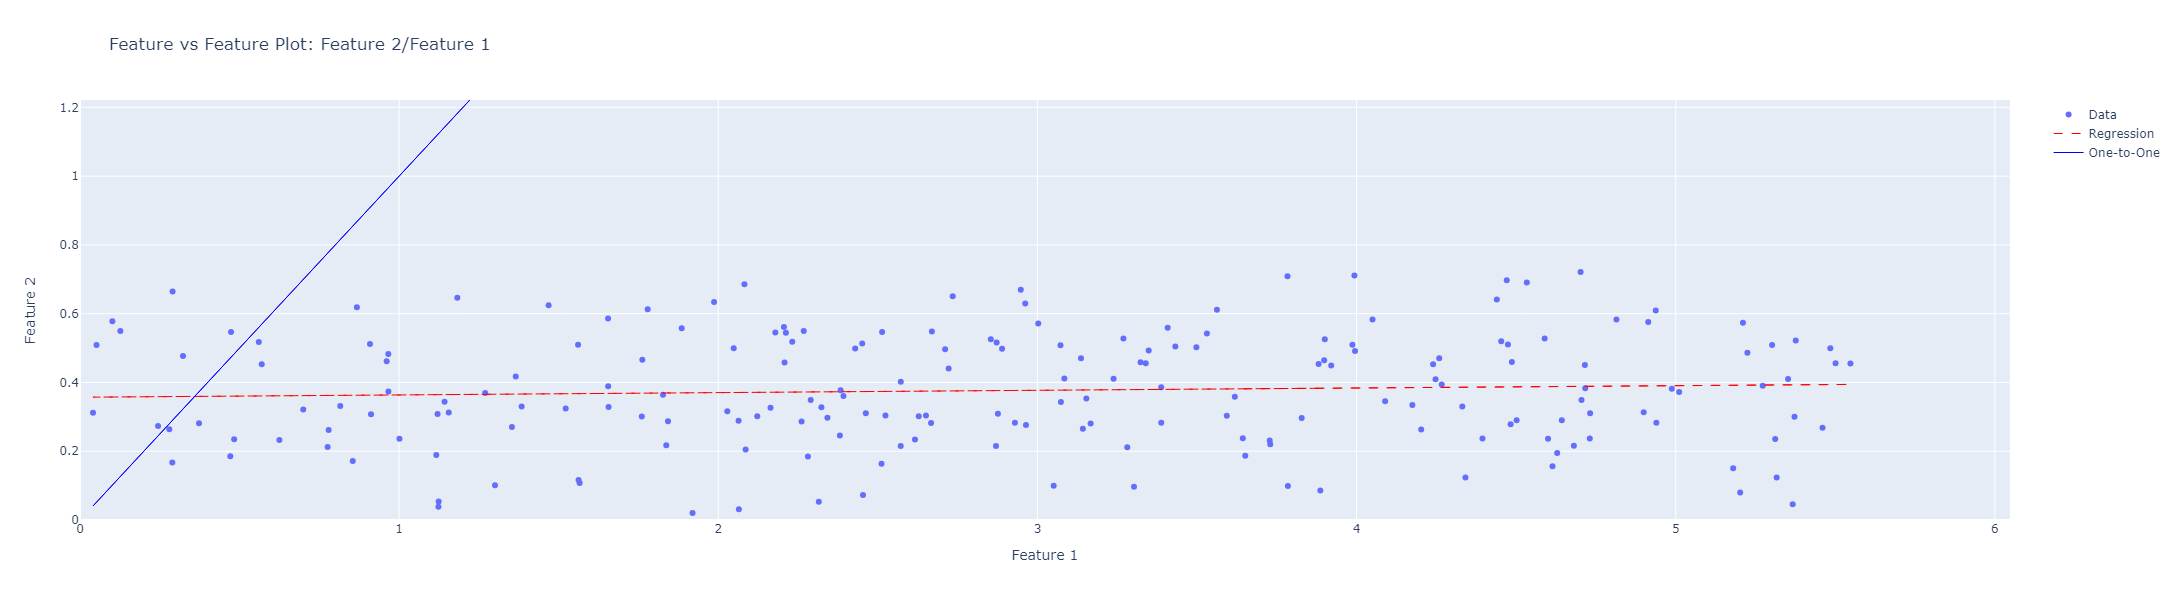

In [10]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

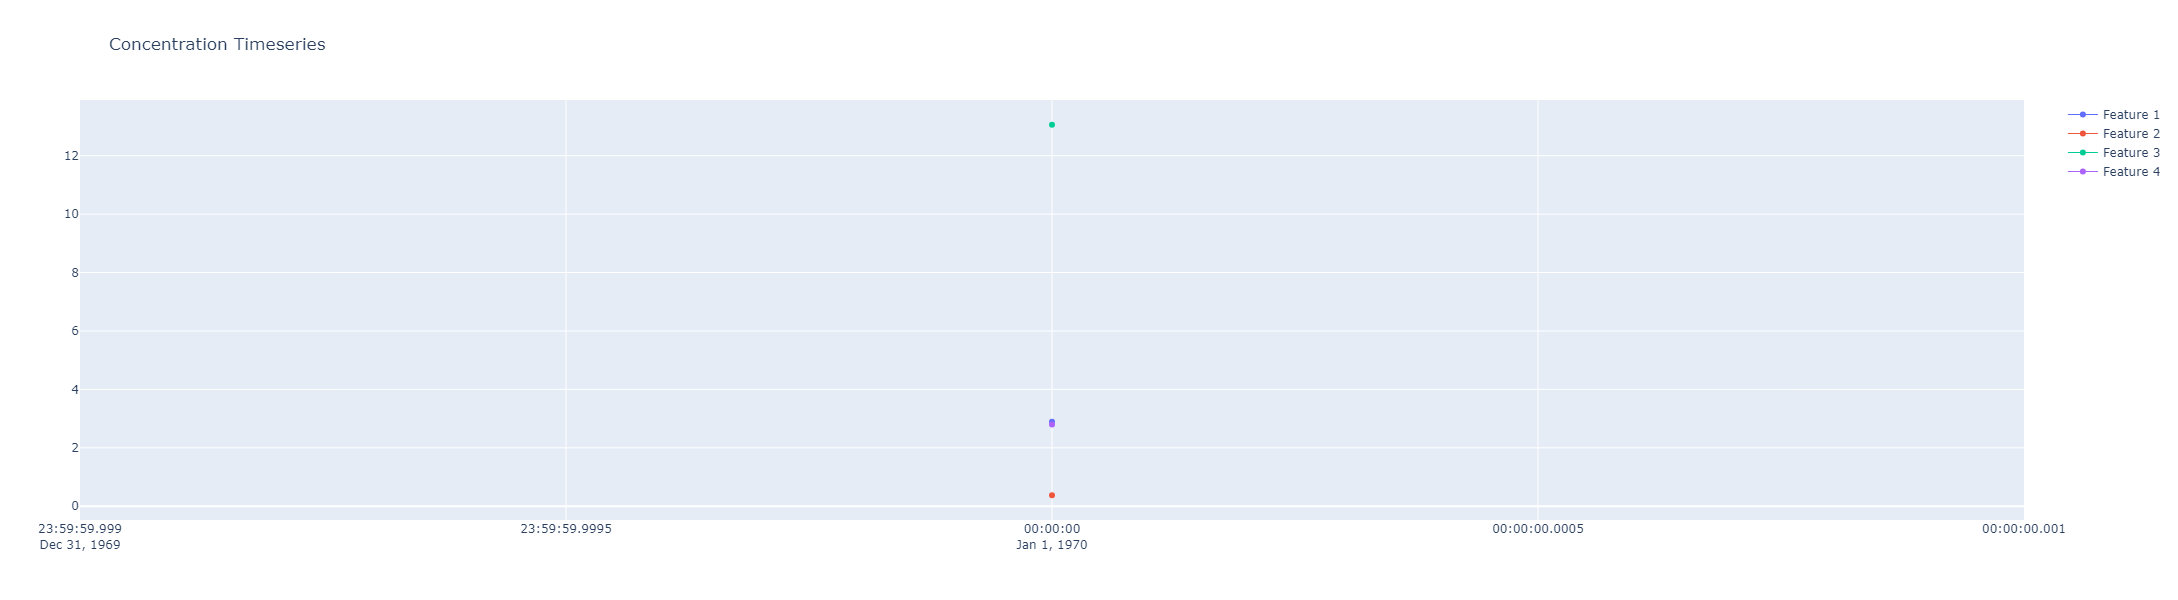

In [11]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0, 1, 2, 3])

In [12]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
_ = sa_models.train()

16-Apr-24 18:08:10 - Model: 1, Q(true): 79.2084, Q(robust): 79.2084, Seed: 8925, Converged: True, Steps: 2464/20000
16-Apr-24 18:08:10 - Model: 2, Q(true): 120.9487, Q(robust): 120.9487, Seed: 77395, Converged: True, Steps: 3413/20000
16-Apr-24 18:08:10 - Model: 3, Q(true): 1960.7002, Q(robust): 850.8397, Seed: 65457, Converged: True, Steps: 1751/20000
16-Apr-24 18:08:10 - Model: 4, Q(true): 87.4841, Q(robust): 87.4841, Seed: 43887, Converged: True, Steps: 1842/20000
16-Apr-24 18:08:10 - Model: 5, Q(true): 100.0783, Q(robust): 100.0783, Seed: 43301, Converged: True, Steps: 3308/20000
16-Apr-24 18:08:10 - Model: 6, Q(true): 93.7903, Q(robust): 93.7903, Seed: 85859, Converged: True, Steps: 1880/20000
16-Apr-24 18:08:10 - Model: 7, Q(true): 88.0343, Q(robust): 88.0343, Seed: 8594, Converged: True, Steps: 1668/20000
16-Apr-24 18:08:10 - Model: 8, Q(true): 84.1712, Q(robust): 84.1712, Seed: 69736, Converged: True, Steps: 1899/20000
16-Apr-24 18:08:10 - Model: 9, Q(true): 412.7467, Q(robust)

CPU times: total: 219 ms
Wall time: 7.35 s


#### Train Model

In [13]:
# Selet the best performing model to review
best_model = sa_models.best_model
sa_model = sa_models.results[best_model]
best_model

15

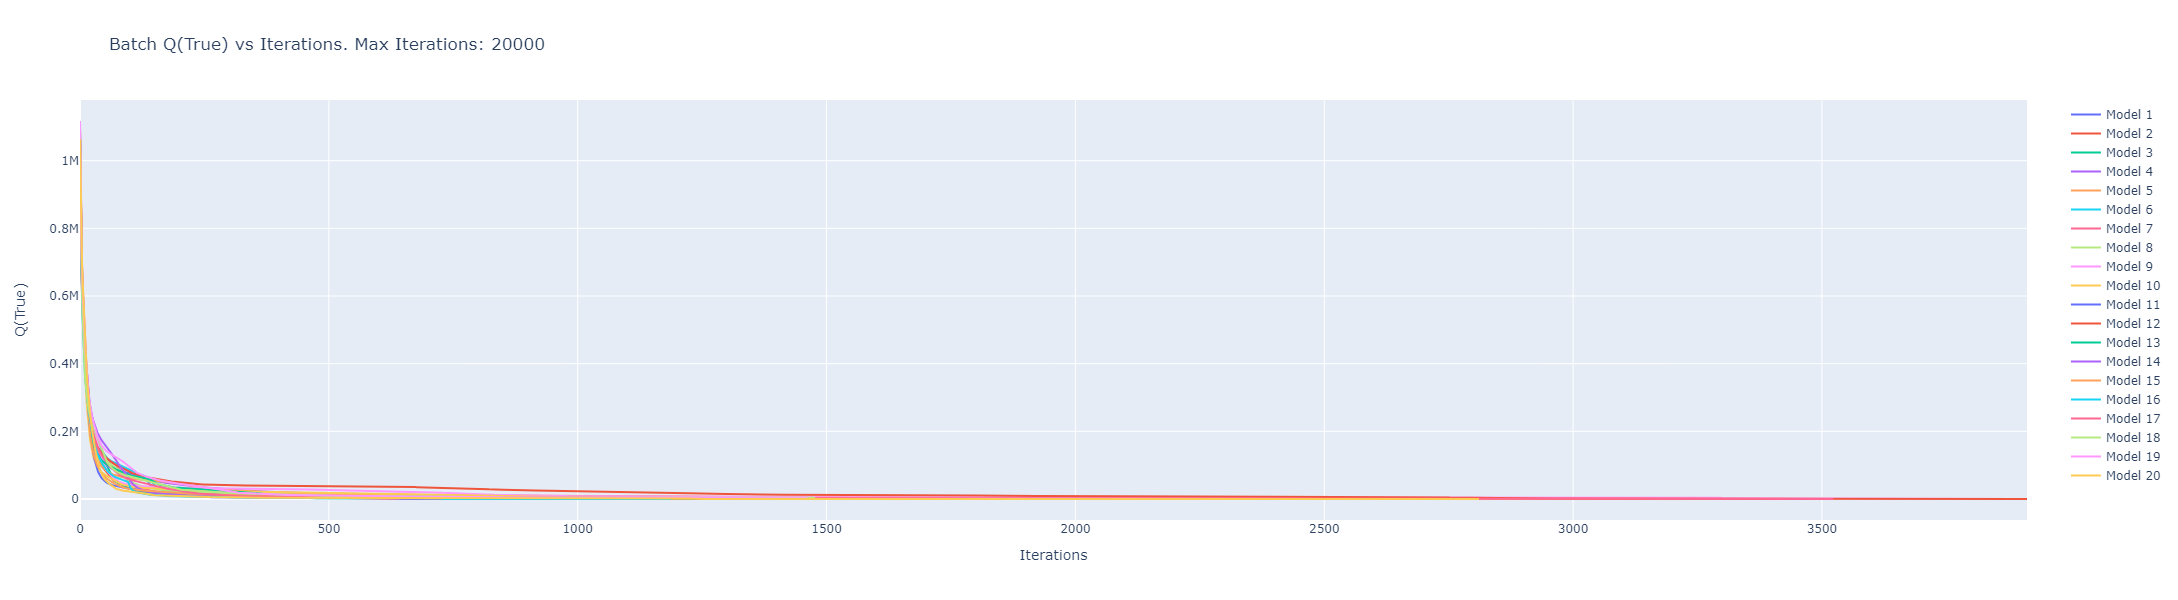

In [14]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

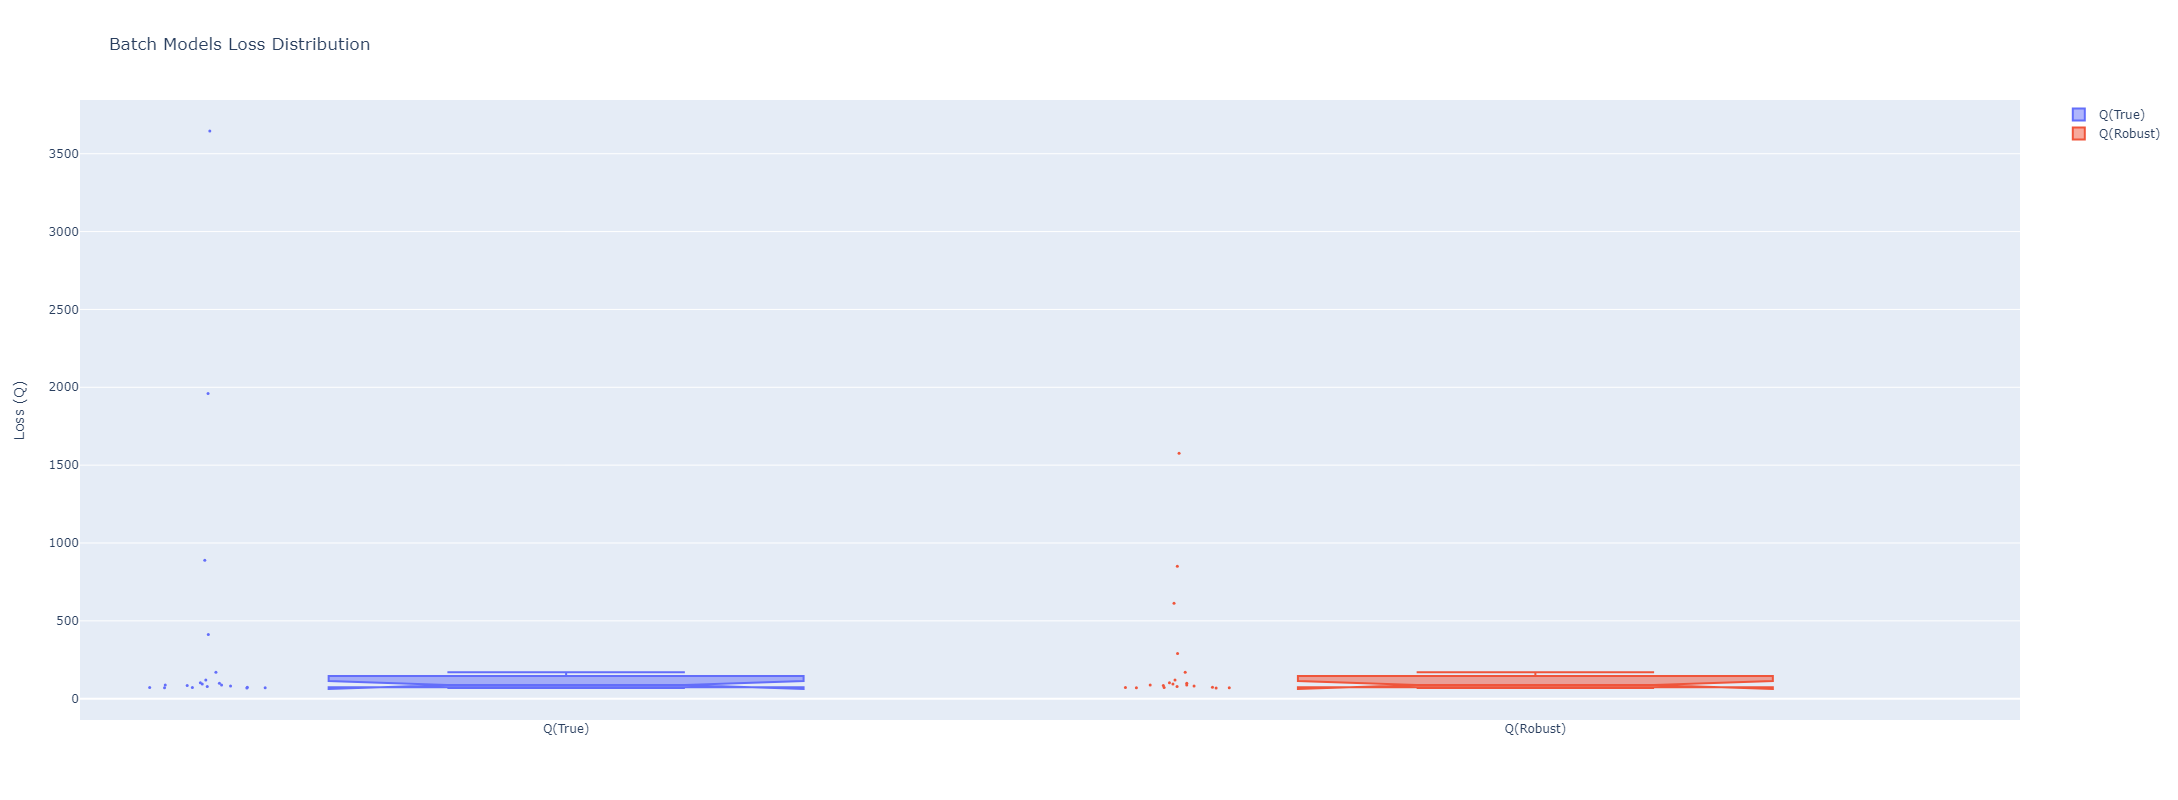

In [15]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [16]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

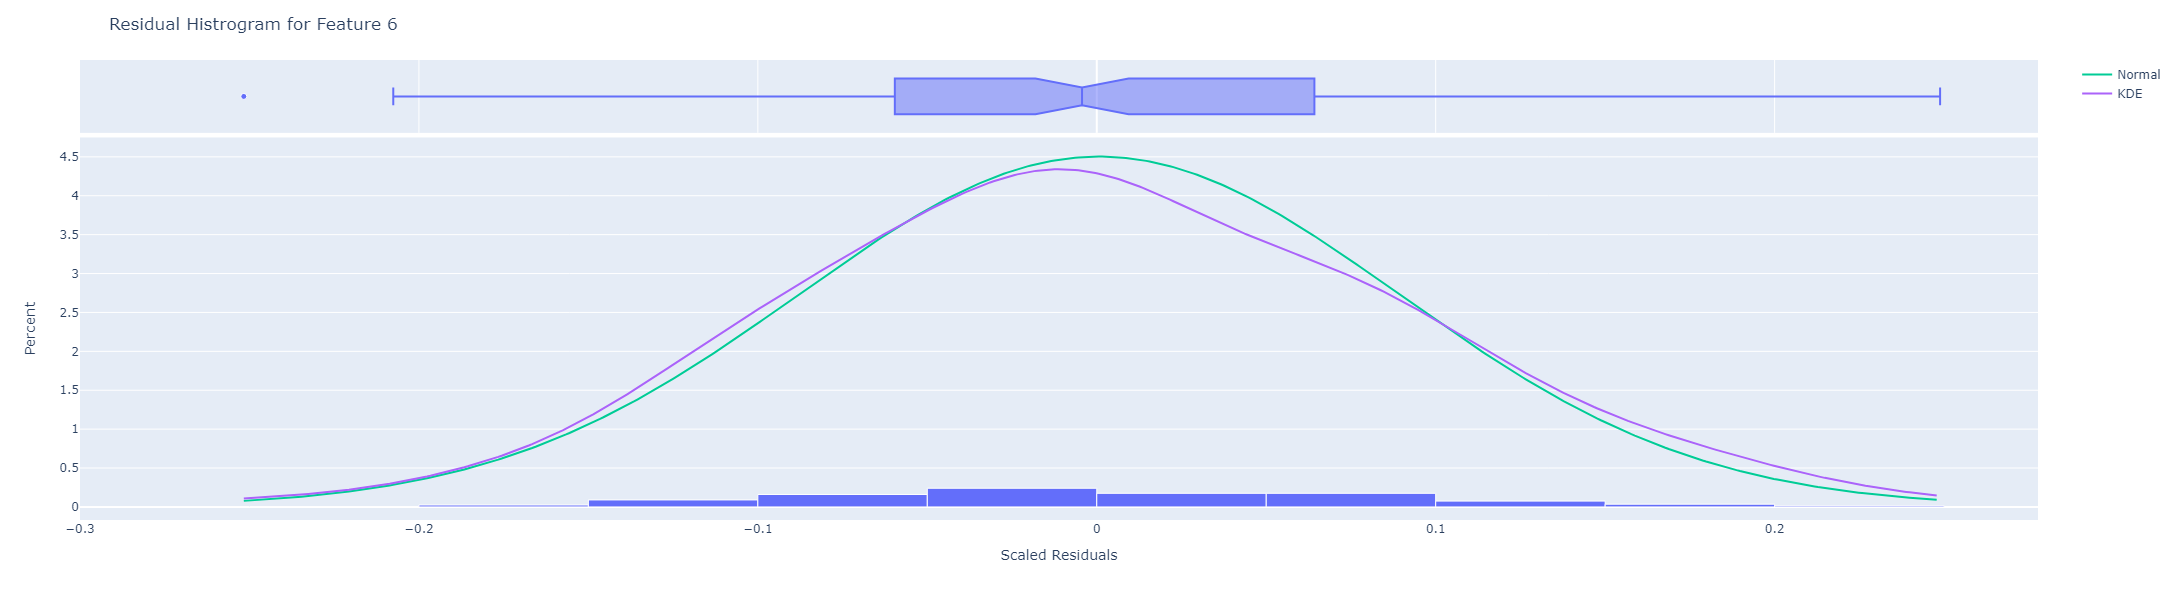

In [17]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=5, abs_threshold=abs_threshold)

In [18]:
print(f"List of Absolute Scaled Residual Greather than: {abs_threshold}. Count: {threshold_residuals.shape[0]}")
threshold_residuals

List of Absolute Scaled Residual Greather than: 3.0. Count: 0


Empty DataFrame
Columns: [Feature 6, datetime]
Index: []

In [19]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

Features Category        r2  Intercept  Intercept SE     Slope  \
0    Feature 1   Strong  0.999917  -0.001029      0.002110  1.000509   
1    Feature 2   Strong  0.999884  -0.000259      0.000315  1.000902   
2    Feature 3   Strong  0.999606   0.031147      0.019070  0.997412   
3    Feature 4   Strong  0.999925  -0.000820      0.002011  1.000469   
4    Feature 5   Strong  0.999733   0.005577      0.016081  0.999423   
5    Feature 6   Strong  0.999930   0.000153      0.001624  0.999850   
6    Feature 7   Strong  0.999719   0.005678      0.010134  0.999241   
7    Feature 8   Strong  0.999839   0.001579      0.003608  0.999351   
8    Feature 9   Strong  0.999811   0.003936      0.010801  0.999418   
9   Feature 10   Strong  0.999760   0.006224      0.014850  0.999414   
10  Feature 11   Strong  0.999752   0.015821      0.015445  0.998678   
11  Feature 12   Strong  0.999697   0.010217      0.011747  0.998854   
12  Feature 13   Strong  0.999878  -0.002607      0.006302  1.000401   
13  Feature 14   Strong  0.999793  -0.011957      0.013690  1.001128   
14  Feature 15   Strong  0.999718   0.006550      0.012717  0.999267   
15  Feature 16   Strong  0.999682   0.002868      0.014444  0.999567   
16  Feature 17   Strong  0.999823   0.000457      0.008791  0.999838   
17  Feature 18   Strong  0.999764   0.014516      0.016599  0.998954   
18  Feature 19   Strong  0.999927   0.000222      0.002752  0.999825   
19  Feature 20   Strong  0.999699   0.014927      0.019187  0.998851   
20  Feature 21   Strong  0.999915  -0.000105      0.003331  0.999964   
21  Feature 22   Strong  0.999649   0.017935      0.024005  0.998821   
22  Feature 23   Strong  0.999769   0.003391      0.013412  0.999659   
23  Feature 24   Strong  0.999720   0.022016      0.012794  0.997677   
24  Feature 25   Strong  0.999747   0.034778      0.018913  0.997556   
25  Feature 26   Strong  0.999842   0.001458      0.004302  0.999629   
26  Feature 27   Strong  0.999922  -0.001801      0.003567  1.000470   
27  Feature 28   Strong  0.999900  -0.002791      0.003977  1.000786   
28  Feature 29   Strong  0.999855   0.000133      0.000848  0.999704   
29  Feature 30   Strong  0.999893  -0.000539      0.000684  1.000816   
30  Feature 31   Strong  0.999779   0.016682      0.010219  0.997883   
31  Feature 32   Strong  0.999707   0.044876      0.021510  0.997098   
32  Feature 33   Strong  0.999758   0.003182      0.017157  0.999695   
33  Feature 34   Strong  0.999766   0.003325      0.006719  0.999295   
34  Feature 35   Strong  0.999942  -0.000146      0.000242  1.000617   
35  Feature 36   Strong  0.999902   0.002224      0.003134  0.999348   
36  Feature 37   Strong  0.999868   0.002254      0.006484  0.999541   
37  Feature 38   Strong  0.999944   0.000548      0.001757  0.999703   
38  Feature 39   Strong  0.999871  -0.002576      0.003715  1.000906   
39  Feature 40   Strong  0.999854   0.003029      0.006674  0.999508   

    Slope SE        SE  SE Regression Anderson Normal Residual  \
0   0.000648  0.000964       0.013615                     15.0   
1   0.000766  0.000125       0.001764                     15.0   
2   0.001408  0.005073       0.071137                     15.0   
3   0.000614  0.001041       0.014696                     15.0   
4   0.001161  0.004957       0.070055                     15.0   
5   0.000593  0.000833       0.011772                     15.0   
6   0.001190  0.003108       0.043908                     15.0   
7   0.000901  0.001274       0.017993                     15.0   
8   0.000977  0.003757       0.053080                     15.0   
9   0.001100  0.004431       0.062615                     15.0   
10  0.001119  0.004633       0.065298                     15.0   
11  0.001236  0.003162       0.044626                     10.0   
12  0.000785  0.002350       0.033214                     15.0   
13  0.001023  0.004550       0.064150                     15.0   
14  0.001193  0.003587       0.050673                     15.0 

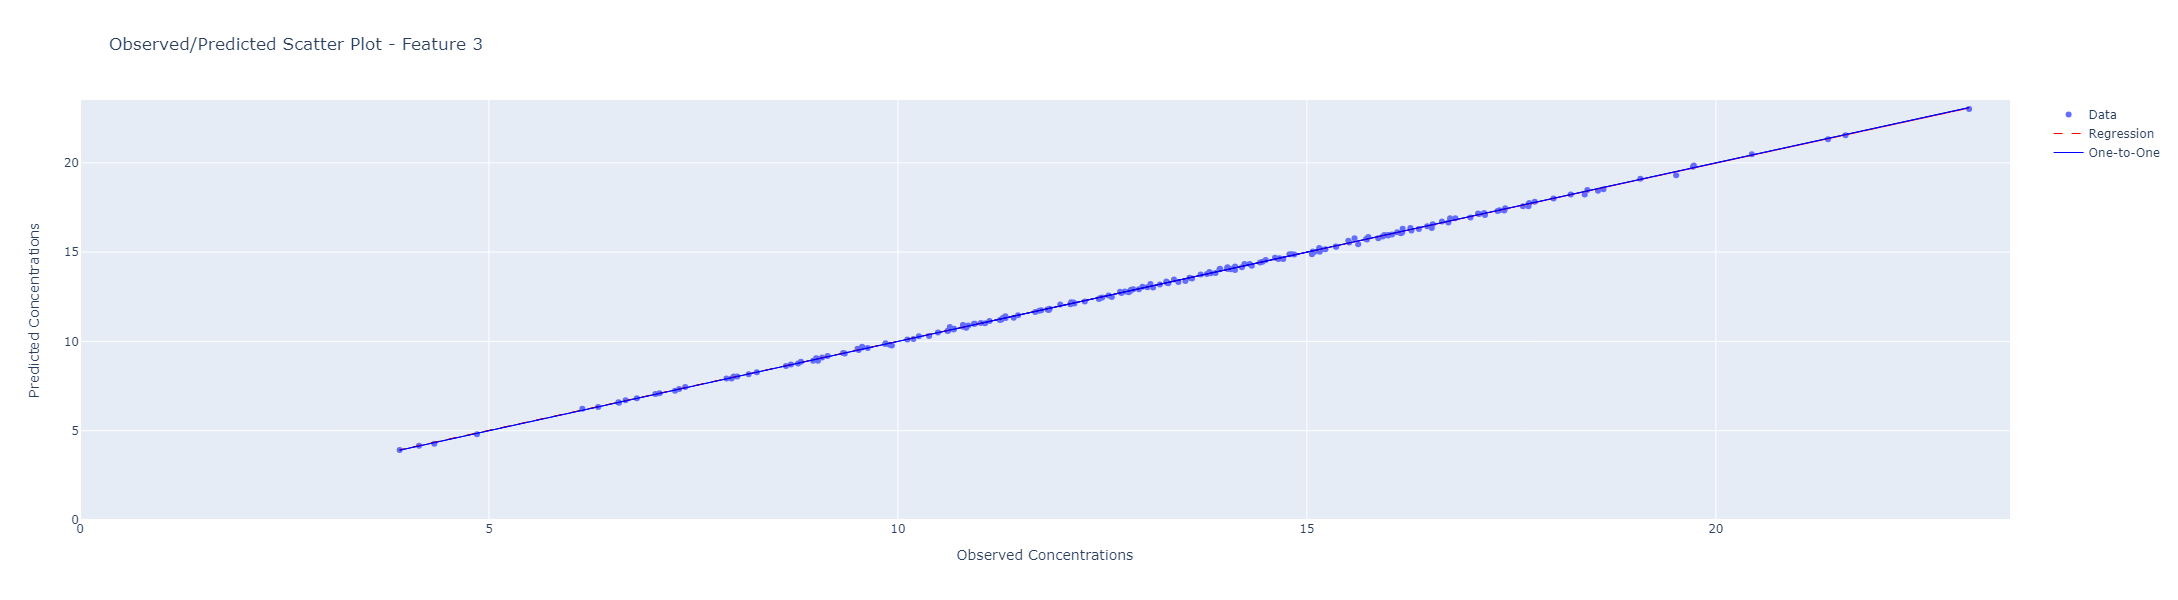

In [20]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed(feature_idx=2)

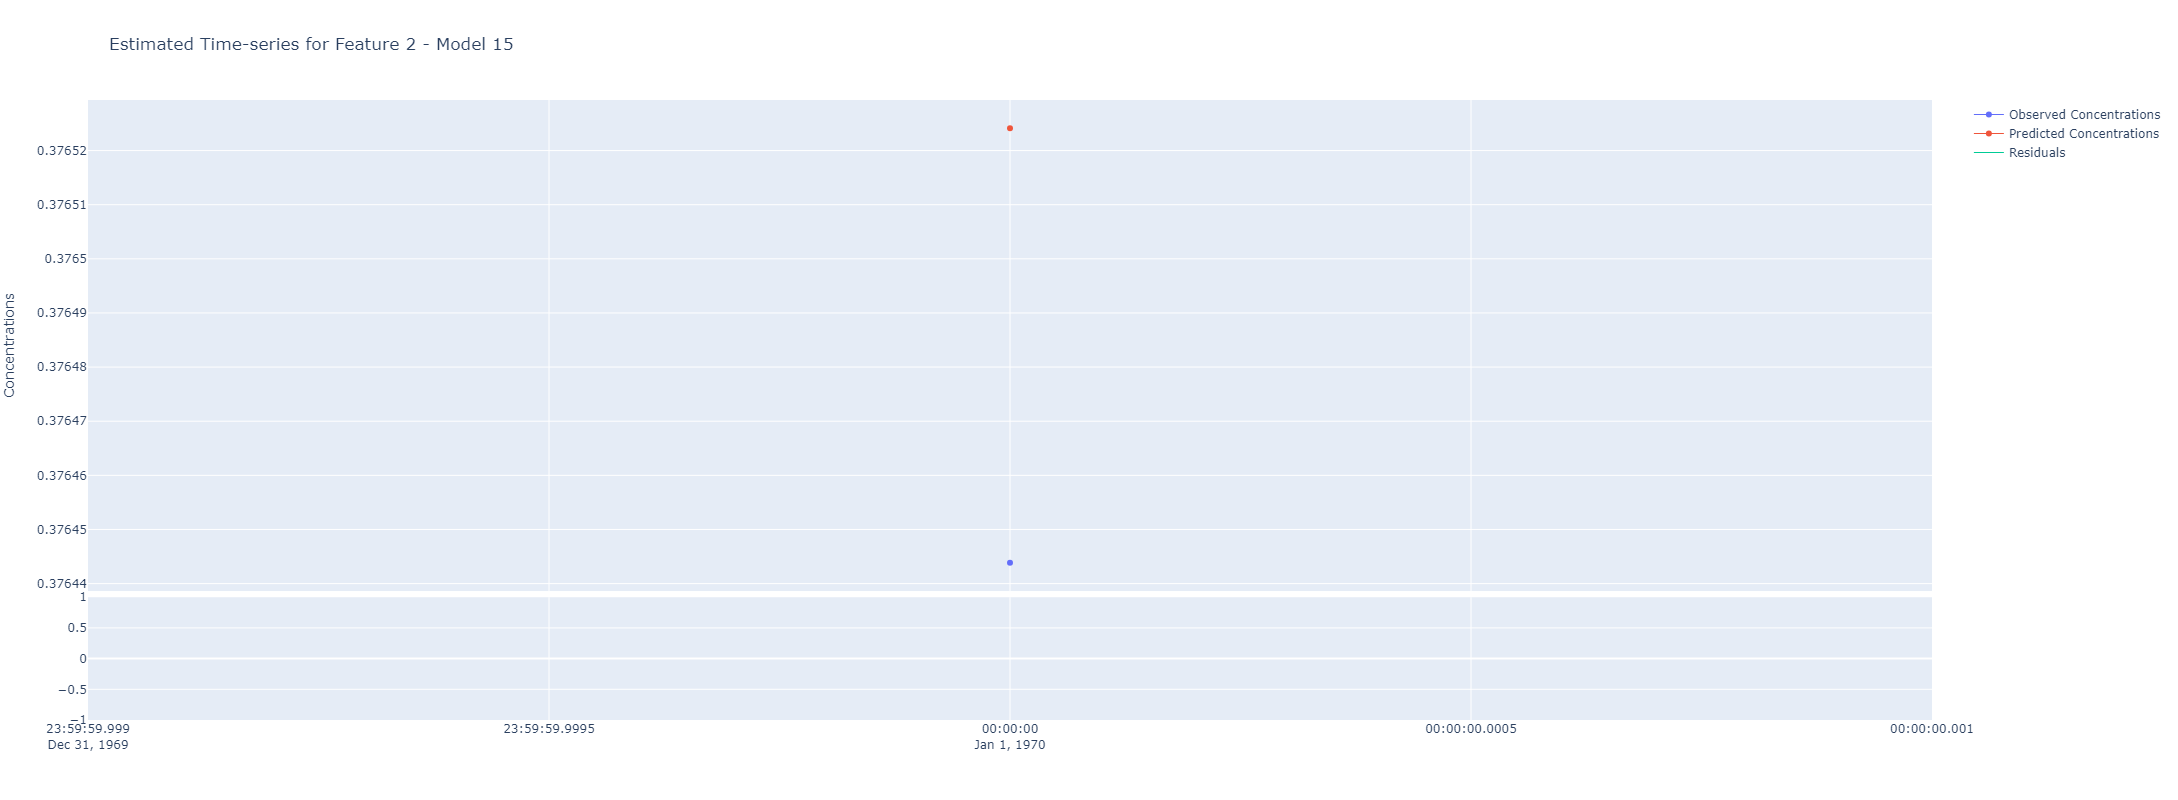

In [21]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries(feature_idx=1)

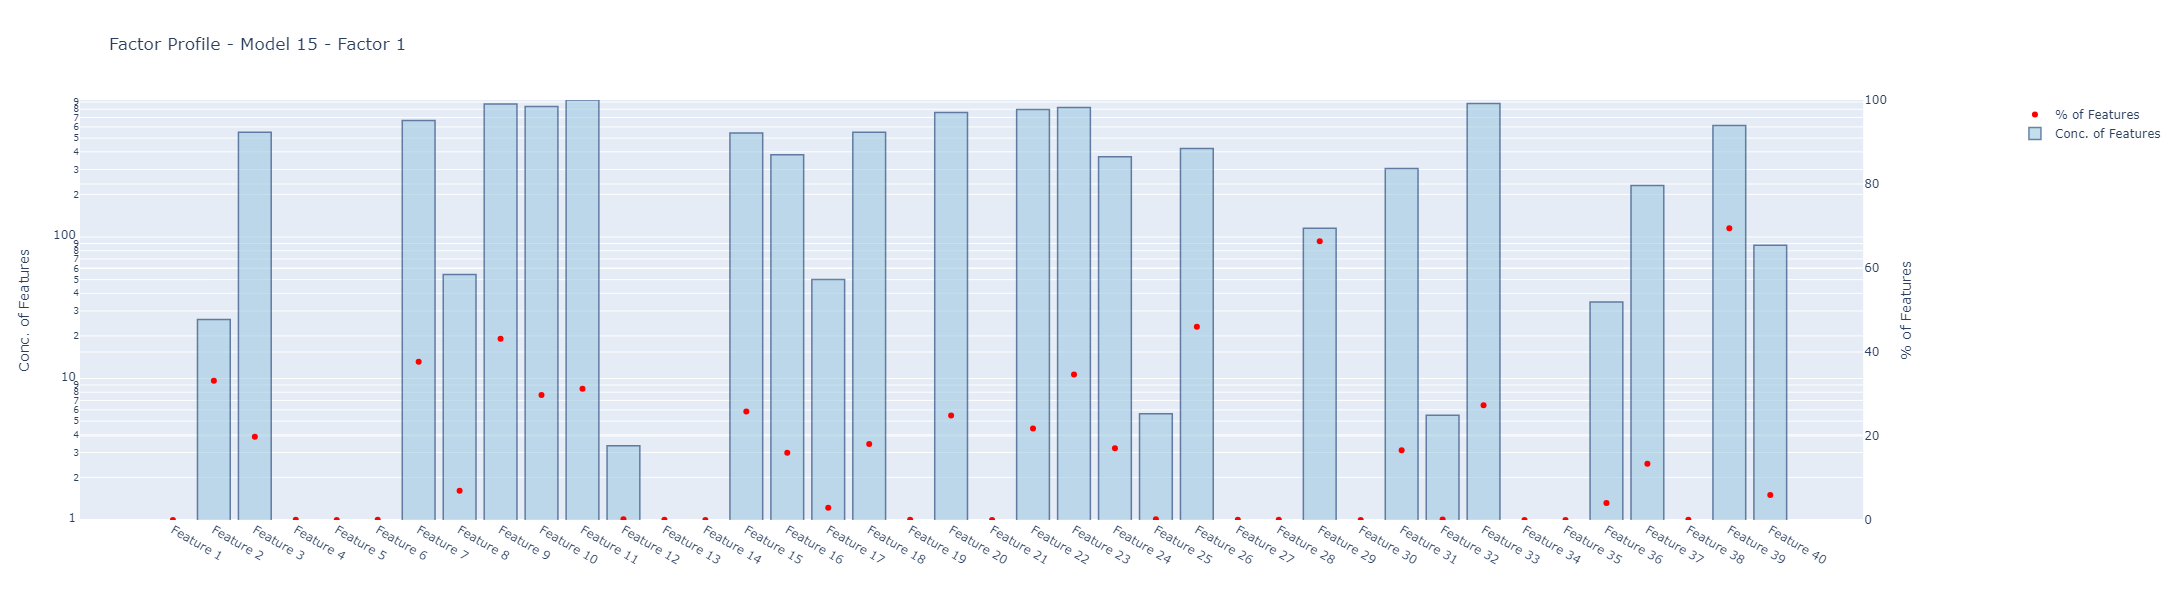

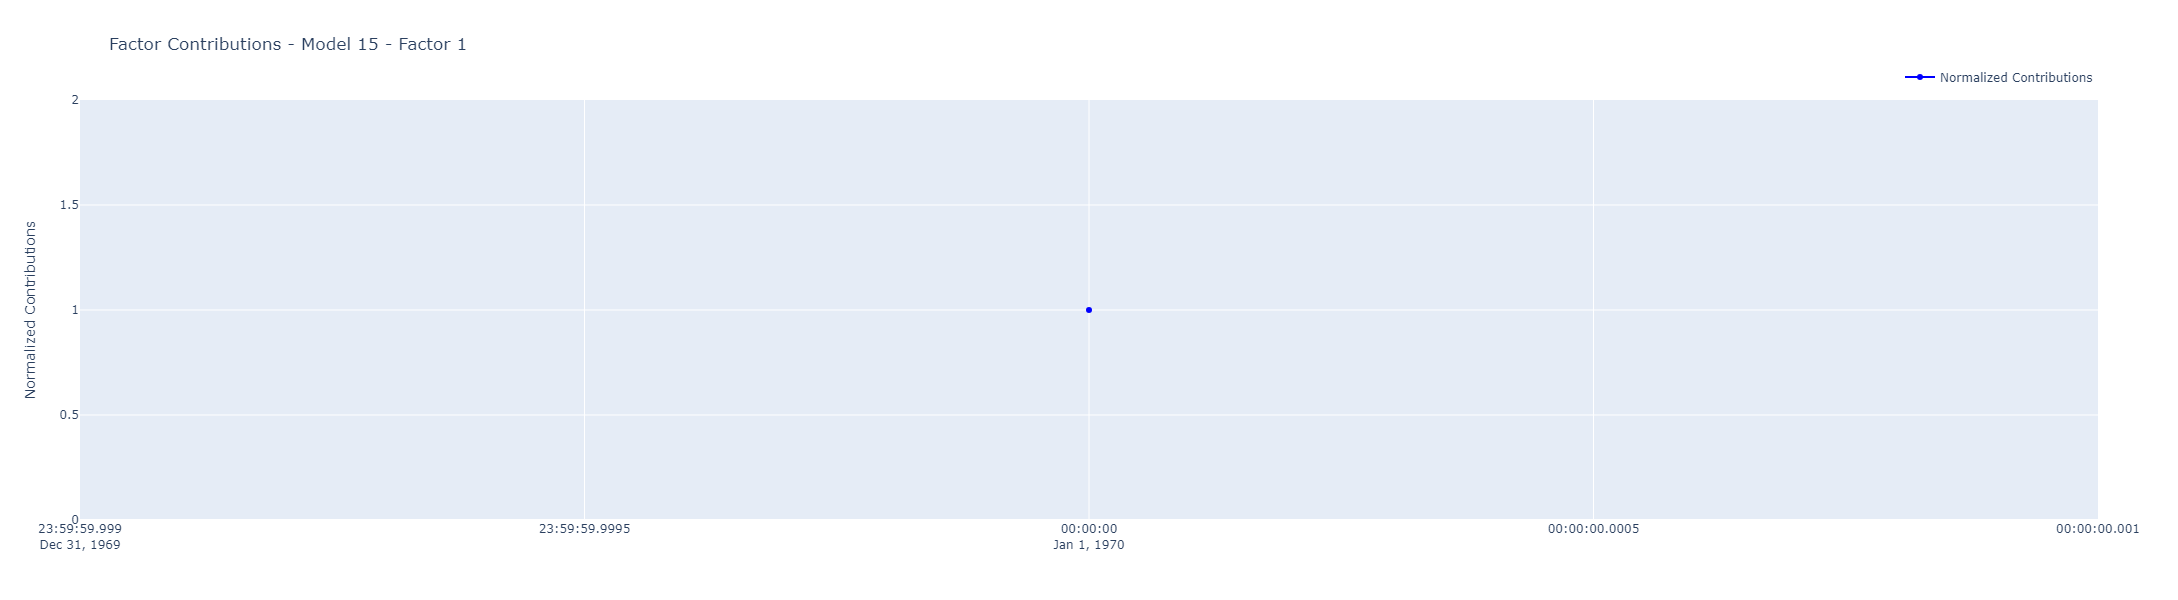

In [22]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

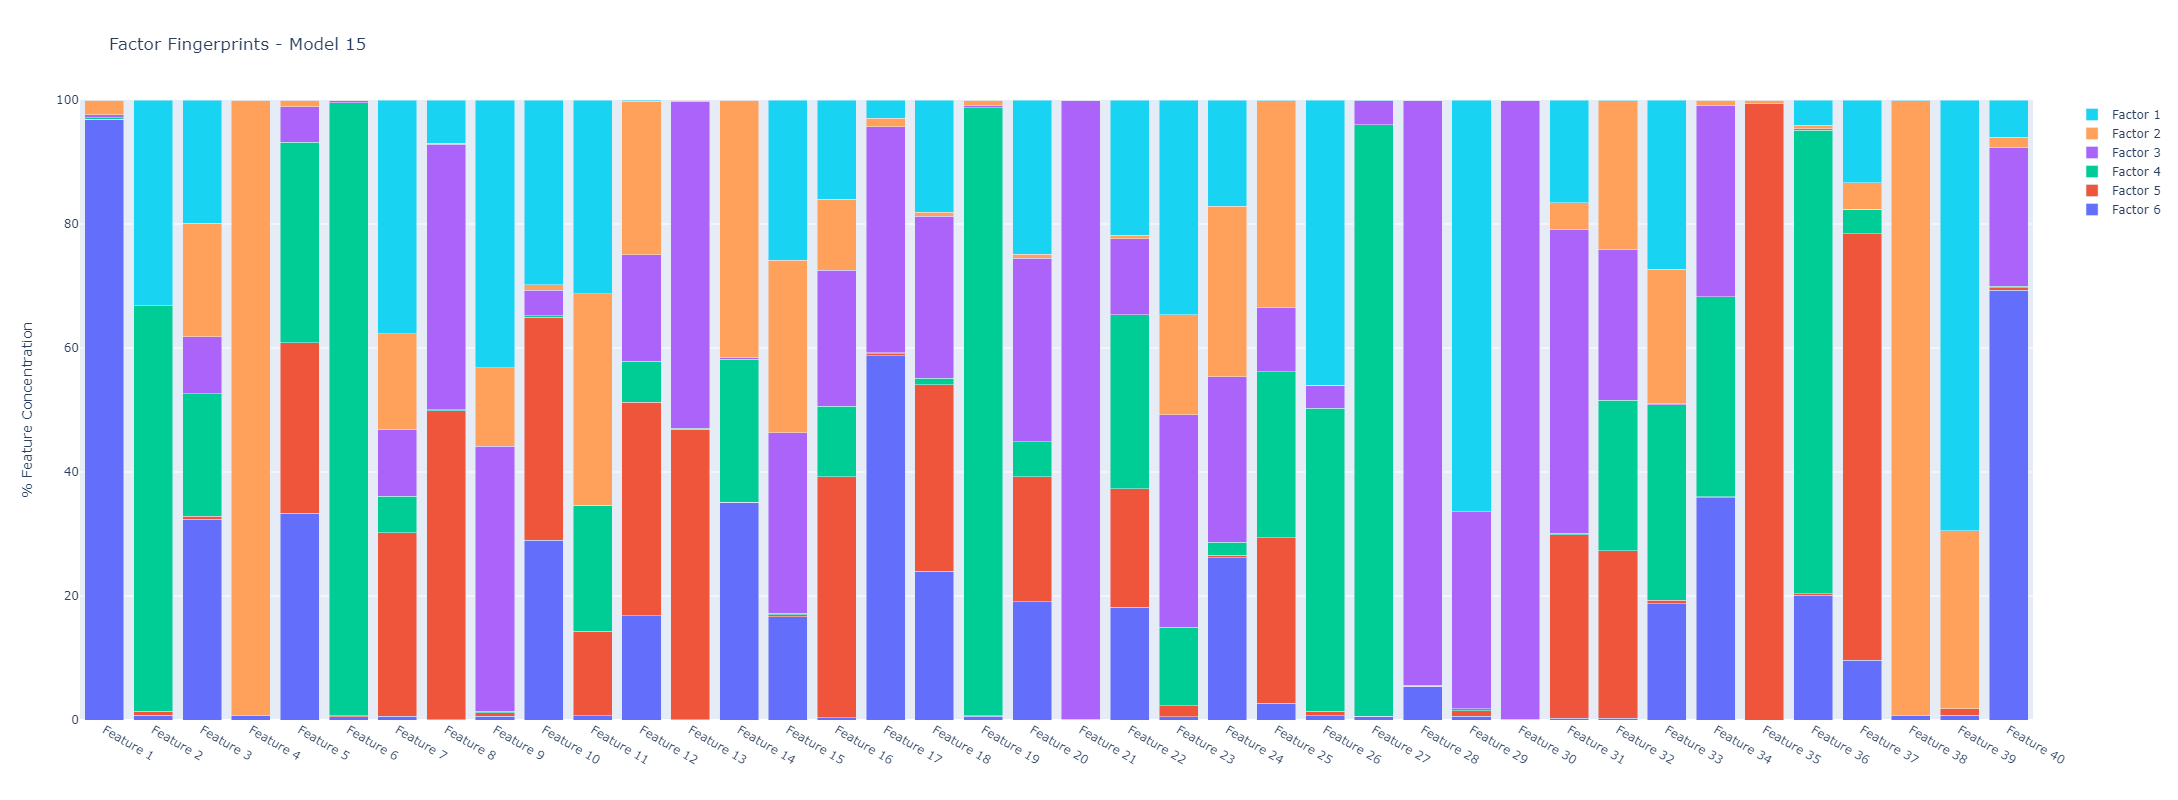

In [23]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

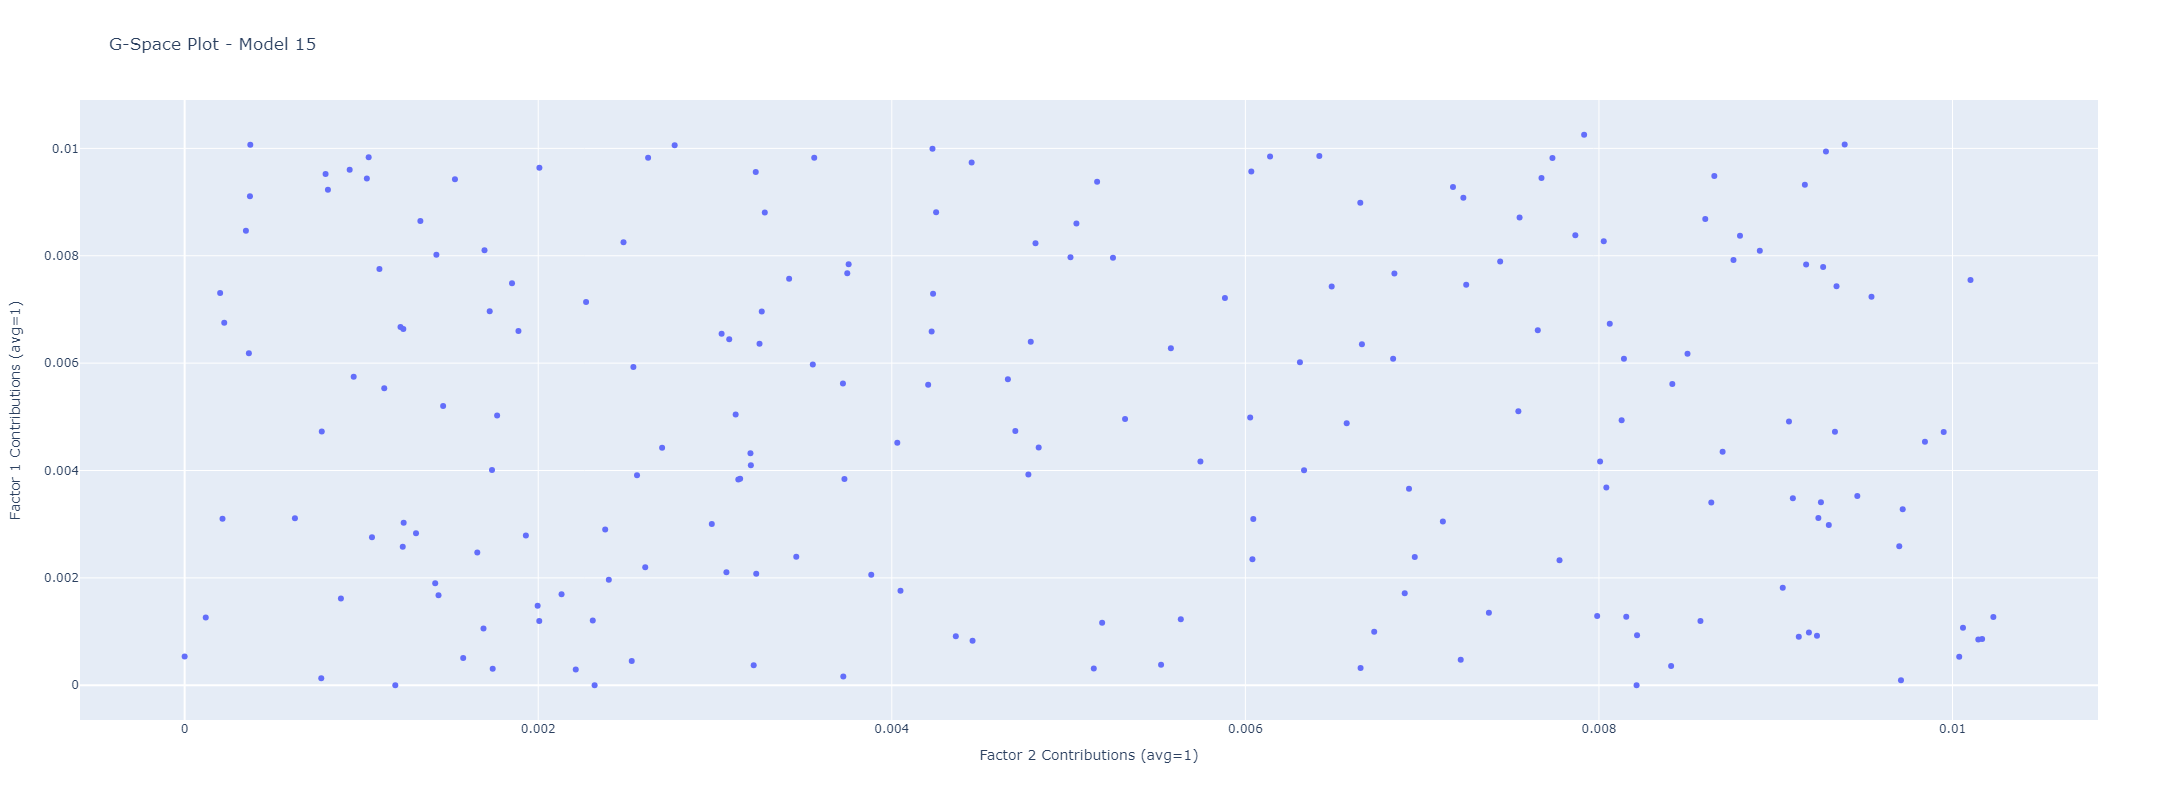

In [24]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

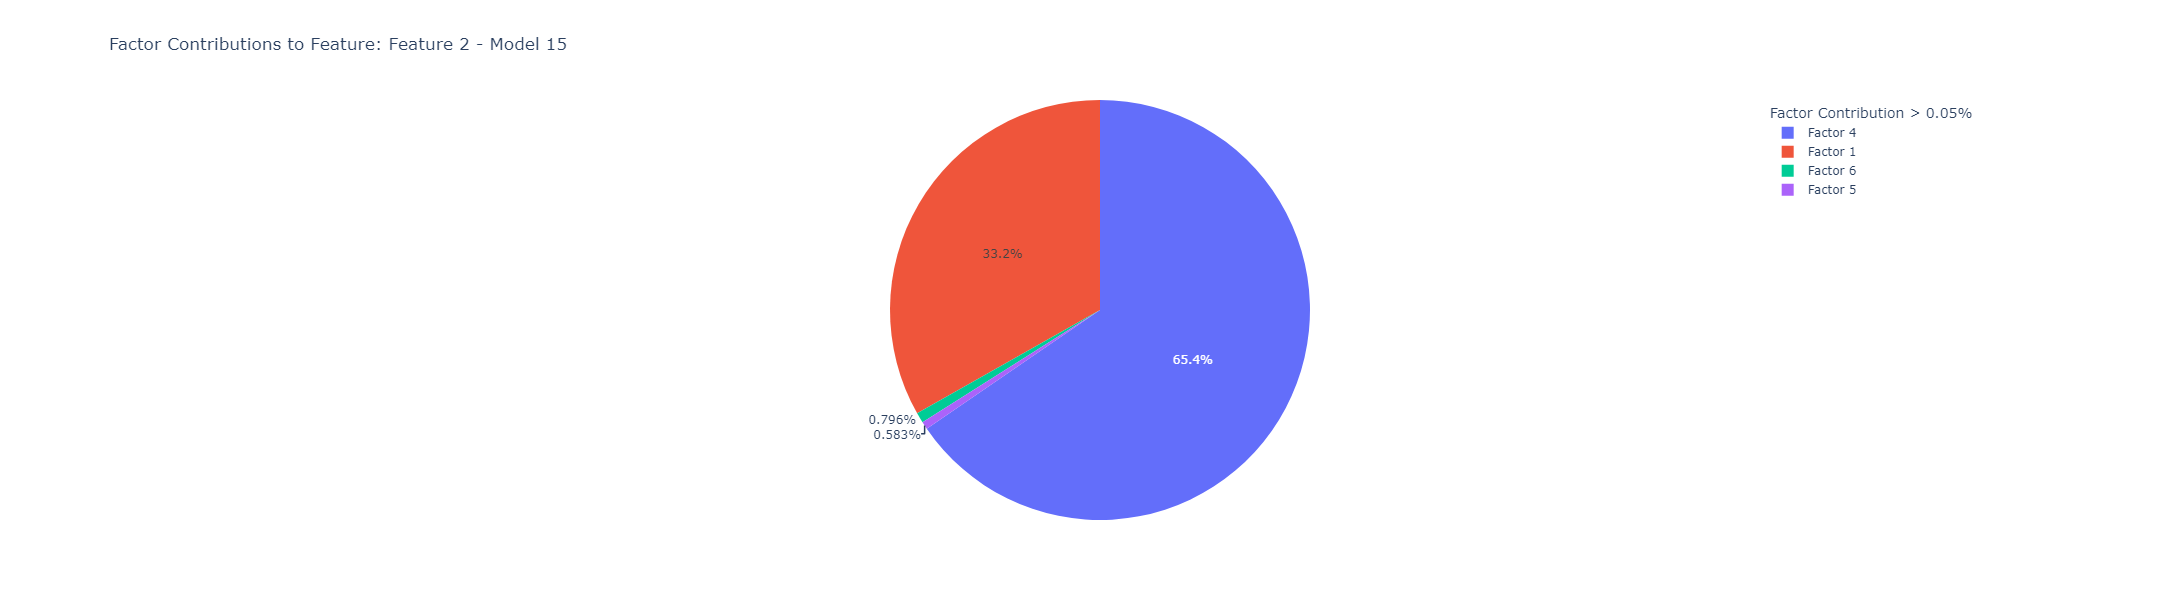

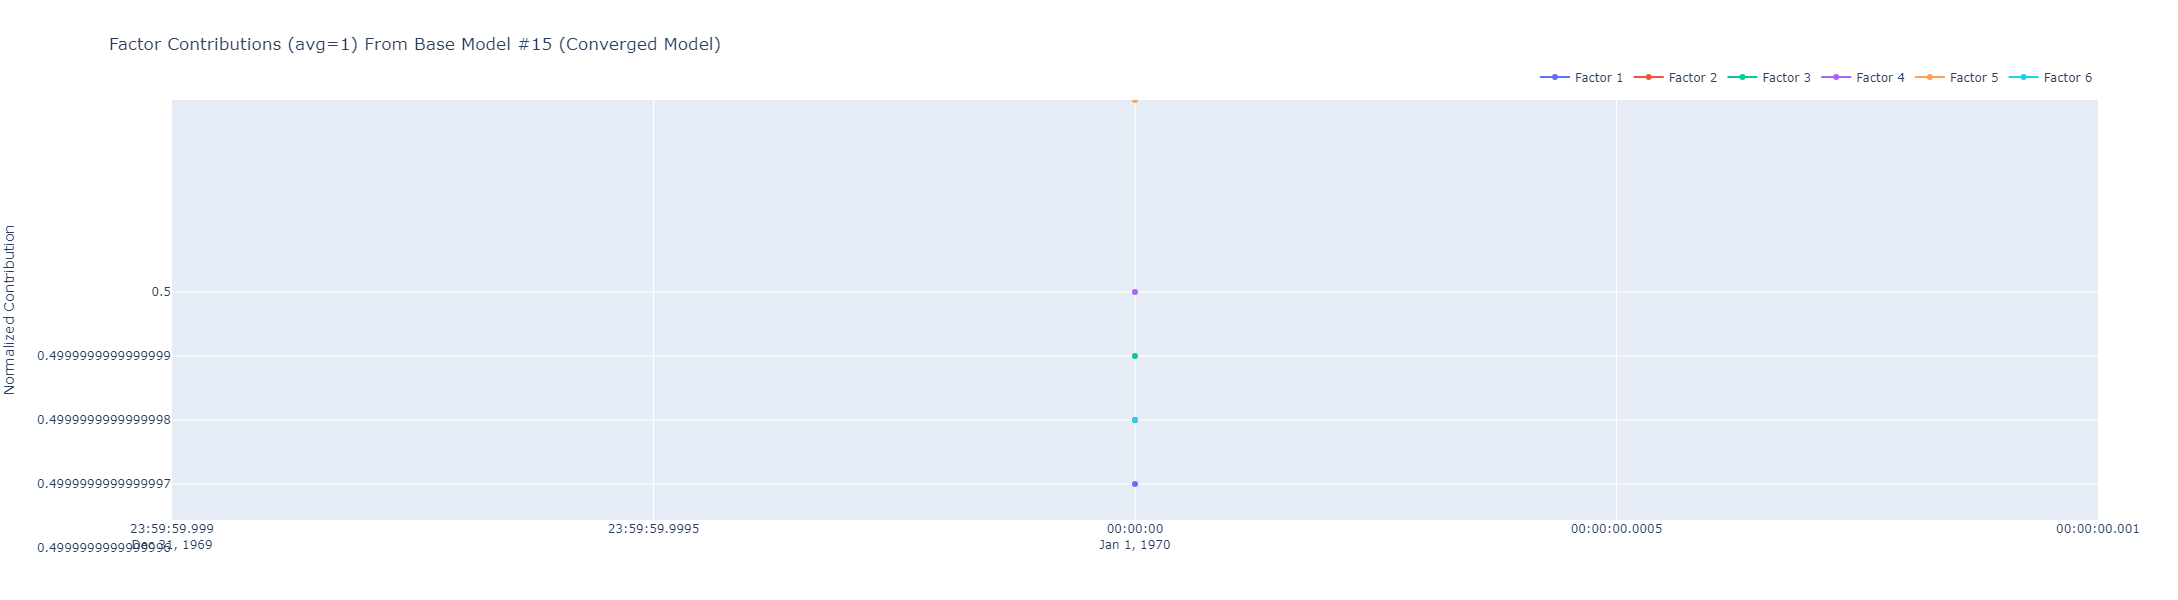

In [25]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [26]:
from eval.factor_comparison import FactorComp

In [27]:
factor_comp = FactorComp(input_df=data_handler.input_data, uncertainty_df=data_handler.uncertainty_data, base_profile_df=syn_profile_df, base_contribution_df=syn_contribution_df, factors_columns=syn_factor_columns, features=syn_columns, batch_sa=sa_models)

In [28]:
factor_comp.compare()

Calculating correlation between factors from each epoch: 100%|█████████████████████████| 20/20 [00:01<00:00, 19.53it/s]


Number of permutations for 6 factors: 720


Calculating average correlation for all permutations for each epoch: 100%|█████████████| 20/20 [01:38<00:00,  4.90s/it]

R2 - Model: 10, Best permutations: ['Factor 1', 'Factor 4', 'Factor 3', 'Factor 2', 'Factor 5', 'Factor 6'], Average R2: 0.9998747267293329, 
Profile R2 Avg: 0.9999068551887973, Contribution R2 Avg: 0.9999026958320621, WH R2 Avg: 0.999814629167139
Profile R2: [0.999933569811177, 0.9999155097745746, 0.9999530928246944, 0.9998389924516642, 0.9999443749860649, 0.9998555912846087], 
Contribution R2: [0.9999275386957409, 0.9998955183862402, 0.9999486071245246, 0.9998561269640067, 0.9998299370195858, 0.9999584468022744], 
WH R2: [0.9998726285596103, 0.999839188190177, 0.9999038416704473, 0.9997311557542089, 0.9997088229431614, 0.9998321378852288]

Base Q(true): 0.9690197282097353, SA Model 10 Q(true): 72.04097701779304


ModuleNotFoundError: No module named 'esat._esat_rust'